In [1]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('train.csv')

In [ ]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [ ]:
train_df.isnull().sum()

image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64

In [ ]:
train_df.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [ ]:
distribution = train_df[['healthy','multiple_diseases','rust','scab']].sum()

C:\Users\merto\AppData\Local\Temp\ipykernel_12632\3640875193.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=distribution.index,y=distribution.values, palette='Set2')


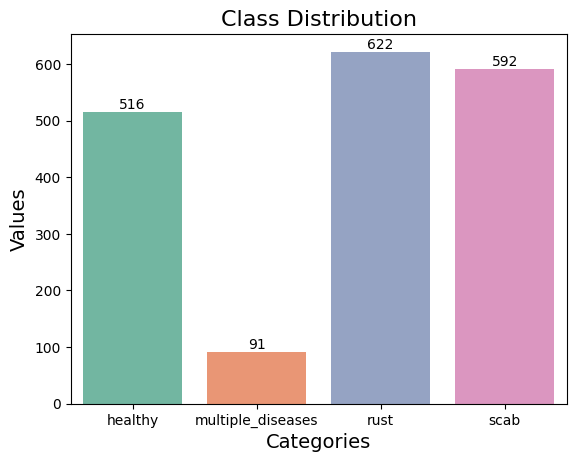

In [ ]:
import seaborn as sns
ax = sns.barplot(x=distribution.index,y=distribution.values, palette='Set2')
ax.set_title("Class Distribution", fontsize=16)
ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Values", fontsize=14)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),  # Explicit input layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # 50% dropout applied
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Prepare class labels (0: healthy, 1: multiple_diseases, 2: rust, 3: scab)
class_labels = np.argmax(train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values, axis=1)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',      # Reason: To balance all classes with equal importance.
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 0.8822674418604651, 1: 5.002747252747253, 2: 0.7319131832797428, 3: 0.7690033783783784}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)

In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the project path
project_path = r"\plant-pathology"

# Clean up 'image_id' column in CSV by removing spaces and adding '.jpg' extension
train_df['image_id'] = train_df['image_id'].str.strip() + ".jpg"

# Define ImageDataGenerator with validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Wider rotation angle
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,
    fill_mode='nearest',     # Fill in empty pixels
    validation_split=0.2     # Set aside 20% of the dataset for validation
)

# Generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(project_path, "images"),
    x_col="image_id",
    y_col=["healthy", "multiple_diseases", "rust", "scab"],
    target_size=(256, 256),
    batch_size=16,
    class_mode="raw",
    subset="training"        # Use the training set
)

# Generator for validation data
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(project_path, "images"),
    x_col="image_id",
    y_col=["healthy", "multiple_diseases", "rust", "scab"],
    target_size=(256, 256),
    batch_size=16,
    class_mode="raw",
    subset="validation"      # Use the validation set
)

Found 1457 validated image filenames.
Found 364 validated image filenames.


In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

C:\Users\merto\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.2219 - loss: 1.4328 - precision_3: 0.5871 - recall_3: 0.0073 - val_accuracy: 0.3379 - val_loss: 1.3870 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.3657 - loss: 1.3972 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.3132 - val_loss: 1.3664 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.3918 - loss: 1.3548 - precision_3: 0.3136 - recall_3: 0.0101 - val_accuracy: 0.4066 - val_loss: 1.3882 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.3562 - loss: 1.3488 - precision_3: 0.7527 - recall_3: 0.0019 - val_accuracy: 0.3324 - val_loss: 1.3688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.3849 - loss: 1.3830 - preci

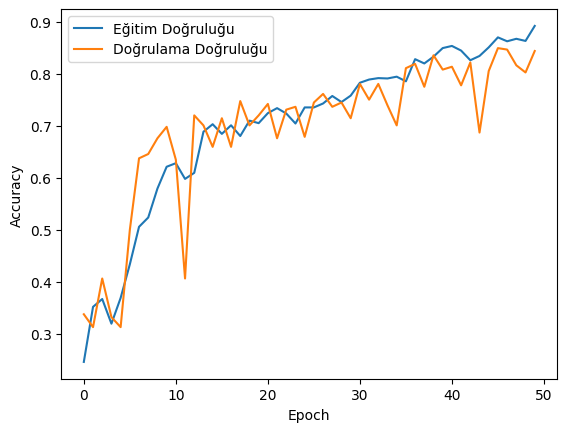

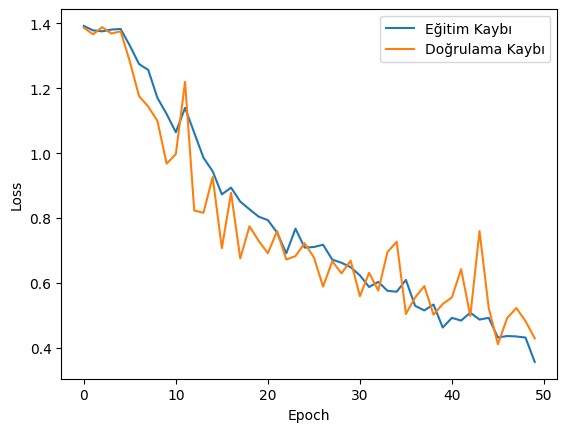

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Add '.jpg' extension to the values in the 'image_id' column of the test CSV
test_df['image_id'] = test_df['image_id'].str.strip() + ".jpg"

# ImageDataGenerator for testing (we only perform normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(project_path, "images"),
    x_col="image_id",
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,   # No labels for test data, so set to None
    shuffle=False      # Keep order for evaluation purposes
)

Found 1821 validated image filenames.


In [ ]:
# Make predictions
predictions = model.predict(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 729ms/step


In [ ]:
# Get prediction probabilities (predictions)
# Probabilities of 4 classes for each image
prediction_probs = predictions  # shape: (num_samples, 4)

# Define class names
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Convert predictions to DataFrame
submission_df = pd.DataFrame(prediction_probs, columns=class_names)
submission_df.insert(0, 'image_id', test_df['image_id'])  # Add image_id

In [ ]:
# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)
class_counts = np.bincount(predicted_classes)
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Print results
for i, count in enumerate(class_counts):
    print(f"Class {class_names[i]}: {count} predictions")

Sınıf healthy: 431 tahmin
Sınıf multiple_diseases: 213 tahmin
Sınıf rust: 744 tahmin
Sınıf scab: 433 tahmin


In [ ]:
# 1. Get image_ids of test images (in 'Test_0', 'Test_1', ... format)
image_ids = test_df['image_id'].str.replace('.jpg', '')  # Remove .jpg extension

# 2. Get prediction probabilities (model output)
prediction_probs = predictions  # shape: (num_samples, 4)

# 3. Create DataFrame
submission_df = pd.DataFrame({
    'image_id': image_ids,
    'healthy': prediction_probs[:, 0],          # First column: healthy probabilities
    'multiple_diseases': prediction_probs[:, 1], # Second column: multiple_diseases probabilities
    'rust': prediction_probs[:, 2],             # Third column: rust probabilities
    'scab': prediction_probs[:, 3]              # Fourth column: scab probabilities
})
# Check the first 5 rows
print(submission_df.head())

  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.000000           0.135323  0.864677  0.000000
1   Test_1  0.000000           0.016705  0.983295  0.000000
2   Test_2  0.048114           0.053355  0.000278  0.898253
3   Test_3  0.947826           0.009298  0.004895  0.037980
4   Test_4  0.000000           0.001032  0.998968  0.000000
